<a href="https://colab.research.google.com/github/Hitomiblood/ProjectsDataScienceMaster/blob/main/KerasGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Final Aprendizaje Profundo
### Nicolas Leonardo Maldonado - AX840282
### Miguel Santiago Gómez Suárez - AX751708
#### Uso de TPU's GPU's y CPU's en Keras

## Creación de Modelo de clasificación de Imagenes usando Keras y entrenando con GPU:

In [1]:
# Importamos las librerias que vamos a usar
from pathlib import Path

In [2]:
# Cargamos las librerías
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [3]:
%%capture
# Obtenemos el DataSet del Link, lo pasamos al Zip y lo descomprimimos
!wget https://www.dropbox.com/s/cv5dfjagvj8fqk8/blindness.zip?dl=1 -O BlindnessDataset.Zip
!unzip BlindnessDataset.Zip

In [4]:
path = Path('blindness/')

In [5]:
trainPath = path/'train'
testPath = path/'test'

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64
IMAGE_SIZE = [512, 512]
Names = ["NO_DR", "MILD","MODERATE","SEVERE","PROLIFERATIVE_DR"]
CLASS_NAMES = ["0", "1","2","3","4"]

In [7]:
# Definir la transformación de datos
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,  # Normalizar los valores de píxeles
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.15  # Especificar el porcentaje de datos para validación
)

In [8]:
# Configurar el generador de datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    trainPath,
    target_size=(512, 512),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Usamos 'categorical' para múltiples clases
    subset='training',
    color_mode='rgb',
    classes=CLASS_NAMES  # Especificamos los nombres de las clases
)

# Configurar el generador de datos de validación
validation_generator = train_datagen.flow_from_directory(
    trainPath,
    target_size=(512, 512),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb',
    classes=CLASS_NAMES
)

Found 2339 images belonging to 5 classes.
Found 410 images belonging to 5 classes.


In [9]:
# Definir la transformación de datos para el conjunto de prueba
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255  # Normalizar los valores de píxeles
)

# Configurar el generador de datos de prueba
test_generator = test_datagen.flow_from_directory(
    testPath,
    target_size=(512, 512),  # Tamaño al que se redimensionarán las imágenes
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Usamos 'categorical' para múltiples clases
    color_mode='rgb',  # Especificar el modo de color RGB
    classes=CLASS_NAMES  # Especificamos los nombres de las clases
)

Found 913 images belonging to 5 classes.


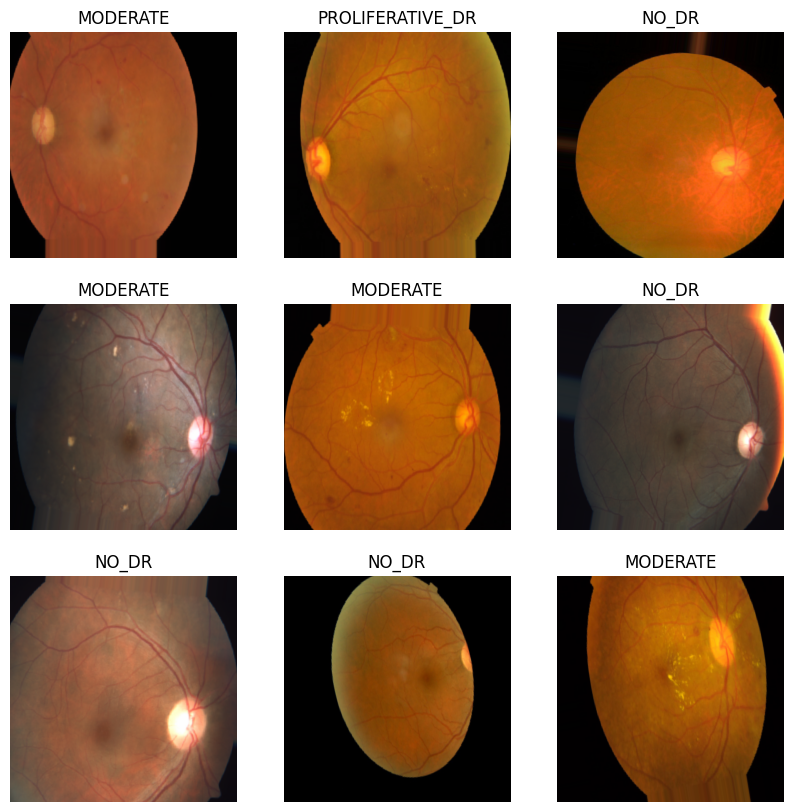

In [10]:
import numpy as np

# Obtener un lote de imágenes y etiquetas de entrenamiento
images, labels = next(train_generator)

# Mostrar algunas imágenes y etiquetas
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])  # Convertir etiquetas codificadas a etiquetas de clase
    plt.title(Names[label_index])  # Usar el nombre de la clase
    plt.axis("off")
plt.show()


In [11]:
def create_blindness_model():
    # Cargar un modelo preentrenado (Xception en este caso) sin la capa de clasificación
    pretrained_model = tf.keras.applications.Xception(
        input_shape=[512, 512, 3],  # Ajustar al tamaño de tus imágenes
        include_top=False,           # No incluir la capa densa final del modelo
        weights='imagenet'          # Utilizar los pesos preentrenados en ImageNet
    )

    # Congelar las capas del modelo preentrenado
    pretrained_model.trainable = False

    # Construir el modelo final
    model = tf.keras.Sequential([
        pretrained_model,                           # Capas preentrenadas
        tf.keras.layers.GlobalAveragePooling2D(),  # Capa de pooling global
        tf.keras.layers.Dense(5, activation='softmax')  # Capa densa de salida con activación softmax
    ])

    # Compilar el modelo
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Crear el modelo
blindness_model = create_blindness_model()

# Imprimir un resumen del modelo
blindness_model.summary()


83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 16, 16, 2048)      20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 20871725 (79.62 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [12]:
import time
import keras

# Especifica el número de épocas
EPOCHS = 12

start_time = time.time()

# Entrena el modelo
history = blindness_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[
        keras.callbacks.ModelCheckpoint("blindness_model_keras.keras", save_best_only=True),
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

end_time = time.time()
execution_time = end_time - start_time
print("Tiempo de ejecución:", execution_time, "segundos")

Epoch 1/12
37/37 [==============================] - 171s 4s/step - loss: 1.2360 - accuracy: 0.5537 - val_loss: 1.0377 - val_accuracy: 0.6707
Epoch 2/12
37/37 [==============================] - 160s 4s/step - loss: 0.9650 - accuracy: 0.6913 - val_loss: 0.9151 - val_accuracy: 0.7195
Epoch 3/12
37/37 [==============================] - 159s 4s/step - loss: 0.8626 - accuracy: 0.7037 - val_loss: 0.8555 - val_accuracy: 0.7293
Epoch 4/12
37/37 [==============================] - 155s 4s/step - loss: 0.8011 - accuracy: 0.7195 - val_loss: 0.7819 - val_accuracy: 0.7341
Epoch 5/12
37/37 [==============================] - 154s 4s/step - loss: 0.7592 - accuracy: 0.7319 - val_loss: 0.7643 - val_accuracy: 0.7293
Epoch 6/12
37/37 [==============================] - 157s 4s/step - loss: 0.7305 - accuracy: 0.7375 - val_loss: 0.7433 - val_accuracy: 0.7366
Epoch 7/12
37/37 [==============================] - 156s 4s/step - loss: 0.7064 - accuracy: 0.7426 - val_loss: 0.6974 - val_accuracy: 0.7537
Epoch 8/12
37

In [13]:
# Evaluación final del modelo en el conjunto de prueba (si lo tienes)
test_loss, test_accuracy = blindness_model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

15/15 [==============================] - 12s 800ms/step - loss: 0.6662 - accuracy: 0.7503
Test Loss: 0.6661970019340515
Test Accuracy: 0.7502738237380981


In [14]:
from huggingface_hub import notebook_login

notebook_login()

In [16]:
from huggingface_hub import push_to_hub_keras

# 1. Guardar el modelo Keras en un archivo
blindness_model.save("blindness_model_keras.keras")
push_to_hub_keras(
    blindness_model,
    "Hitomiblood/blindness_modelKeras2"
)

saved_model.pb:   0%|          | 0.00/2.30M [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/489k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

variables.data-00000-of-00001:   0%|          | 0.00/83.6M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Hitomiblood/blindness_modelKeras2/commit/5a82d325e4a3fb1be01431e4d88439ab624b62d4', commit_message='Push Keras model using huggingface_hub.', commit_description='', oid='5a82d325e4a3fb1be01431e4d88439ab624b62d4', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
%%capture
# Obtenemos el DataSet del Link, lo pasamos al Zip y lo descomprimimos
!wget https://www.dropbox.com/s/cv5dfjagvj8fqk8/blindness.zip?dl=1 -O BlindnessDataset.Zip
!unzip BlindnessDataset.Zip

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# 3. Utilizar el modelo en un entorno de Hugging Face
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("Hitomiblood/blindness_model_keras")  # ID del modelo en Hugging Face Hub

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [ ]:
# Ahora puedes utilizar el modelo como quieras, por ejemplo:
# Definir una función para hacer predicciones
def predict_function(img):
    # Procesar la imagen según sea necesario
    # Por ejemplo, si necesitas redimensionarla a 512x512 y normalizarla, puedes hacerlo aquí

    # Hacer la predicción con el modelo
    prediction = model.predict(np.expand_dims(image_array, axis=0))
    return prediction

In [ ]:
from PIL import Image
import numpy as np

# Cargar la imagen
image_path = "/content/blindness/test/0/002c21358ce6.png"
image = Image.open(image_path)

# Redimensionar la imagen si es necesario
# Por ejemplo, si tu modelo espera imágenes de 512x512, puedes redimensionarla así:
image = image.resize((512, 512))

# Convertir la imagen a un array numpy y normalizar los valores de píxeles
image_array = np.array(image) / 255  # Normalización

# Hacer la predicción utilizando la función predict_function
prediction = predict_function(image_array)

1/1 [==============================] - 4s 4s/step


In [ ]:
prediction

array([[9.9569196e-01, 1.5791574e-03, 1.5773632e-03, 3.7737007e-04,
        7.7426585e-04]], dtype=float32)